`matplotlib` magic command (only necessary for `jupyter` notebooks).

In [1]:
%matplotlib inline

# `cityseer`

`cityseer` is a collection of computational tools for fine-grained network and land-use analysis, useful for assessing the morphological precursors to vibrant neighbourhoods. It is underpinned by rigorous network-based methods that have been developed from the ground-up specifically for hyperlocal analysis at the pedestrian scale.

The use of `python` facilitates interaction with popular tools for network, geospatial, and scientific data analysis, i.e. [`networkX`](https://networkX.github.io/), [`shapely`](https://shapely.readthedocs.io), and the [`numpy`](http://www.numpy.org/) stack. The underlying algorithms are designed for efficient large-scale urban analysis and have been implemented in [`numba`](https://numba.pydata.org/) JIT compiled code.

`cityseer` revolves around networks (graphs). If you're comfortable with `numpy` and abstract data handling, then the underlying data structures can be created and manipulated directly. However, it is generally more convenient to sketch the graph using [`networkX`](https://networkX.github.io/) and to let `cityseer` take care of initialising and converting the graph for you.

Name: 
Type: Graph
Number of nodes: 56
Number of edges: 77
Average degree:   2.7500 



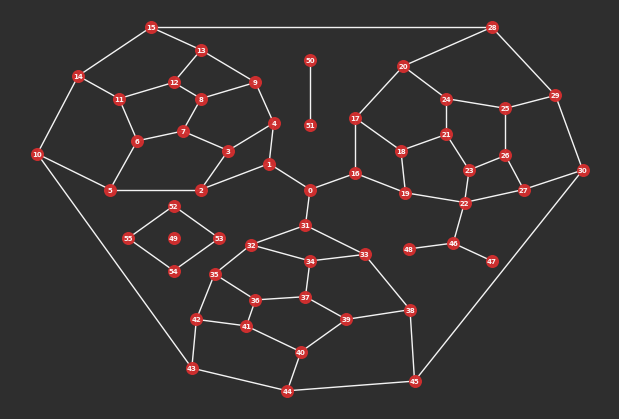

In [2]:
# any networkX graph with 'x' and 'y' node attributes will do
# here we'll use the cityseer mock module to generate an example networkX graph
import networkx as nx
from cityseer.util import mock
from cityseer.util import plot

G = mock.mock_graph()
print(nx.info(G), '\n')

# let's plot the network
plot.plot_nX(G, labels=True, dpi=100)

The [`util.graphs`](https://cityseer.github.io/cityseer/util/graphs.html) module contains a collection of convenience functions for the preparation and conversion of `networkX` graphs. These functions are designed to work with raw `shapely` [`Linestring`](https://shapely.readthedocs.io/en/latest/manual.html#linestrings) geometries that have been assigned to the edge (link) `geom` attributes. The benefit to this approach is that the geometry of the network is decoupled from the topology: the topology is consequently free from distortions which would otherwise confound centrality and other metrics.

There are generally two scenarios when creating a street network graph:

1. In the ideal case, if you have access to a high-quality street network dataset -- which keeps the topology of the network separate from the geometry of the streets -- then you would construct the network based on the topology while assigning the roadway geometries to the respective edges spanning the nodes. [OS Open Roads](https://www.ordnancesurvey.co.uk/business-and-government/products/os-open-roads.html) is a good example of this type of dataset. Assigning the geometries to an edge involves A) casting the geometry to a [`shapely`](https://shapely.readthedocs.io) `LineString`, and B) assigning this geometry to the respective edge by adding the `LineString` geometry as a `geom` attribute. i.e. `G[start_node][end_node]['geom'] = linestring_geom`.

2. In reality, most data-sources are not this refined and will represent roadway geometries by adding additional nodes to the network. For a variety of reasons, this is not ideal and you may want to follow the [`Graph Cleaning`](https://cityseer.github.io/cityseer/guide/cleaning) guide; in these cases, the [`graphs.nX_simple_geoms`](https://cityseer.github.io/cityseer/util/graphs.html#nx-simple-geoms) method can be used to generate the street geometries, after which several methods can be applied to remove frivolous nodes. For example, [`nX_wgs_to_utm`](https://cityseer.github.io/cityseer/util/graphs.html#nx-wgs-to-utm) for coordinate conversions; [`nX_remove_dangling_nodes`](https://cityseer.github.io/cityseer/util/graphs.html#nx-remove-dangling-nodes) to remove roadway stubs, [`nX_remove_filler_nodes`](https://cityseer.github.io/cityseer/util/graphs.html#nx-remove-filler-nodes) to strip-out filler nodes, and [`nX_consolidate_parallel`](https://cityseer.github.io/cityseer/util/graphs.html#nx-consolidate-parallel) to further simplify the network.  

In [3]:
from cityseer.util import graphs
# provide your own shapely geometries if you need precise street lengths / angles
# else, auto-generate simple geometries from the start to end node of each network edge
G = graphs.nX_simple_geoms(G)

INFO:cityseer.util.graphs:Generating simple (straight) edge geometries.


Once the network is prepared, [`nX_decompose`](https://cityseer.github.io/cityseer/util/graphs.html#nx-decompose) can be used for the purpose of generating granular graph representations; whereas [`nX_to_dual`](https://cityseer.github.io/cityseer/util/graphs.html#nx-to-dual) can be used to cast a primal graph representation to its dual.

INFO:cityseer.util.graphs:Decomposing graph to maximum edge lengths of 50.


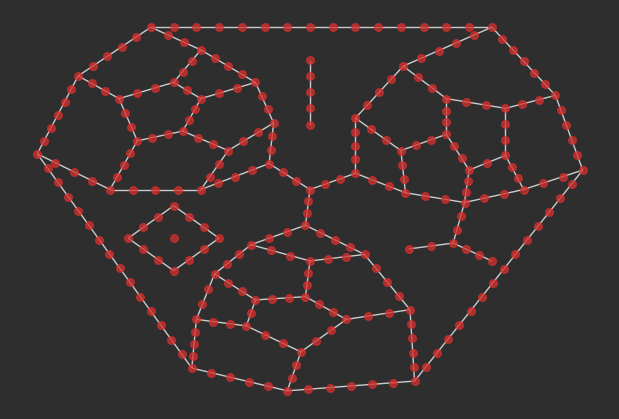

In [4]:
# optionally decompose
G_decomp = graphs.nX_decompose(G, 50)
plot.plot_nX(G_decomp, labels=False, dpi=100)

INFO:cityseer.util.graphs:Converting graph to dual.


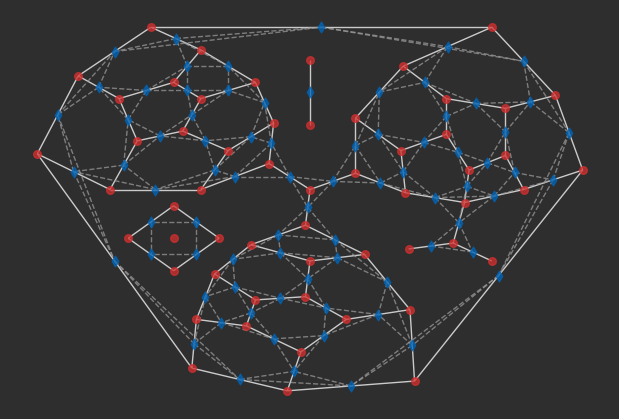

In [5]:
# optionally cast to a dual network
G_dual = graphs.nX_to_dual(G)
# here we are plotting the newly decomposed graph (blue) against the original graph (red)
plot.plot_nX_primal_or_dual(G, G_dual, dpi=100)

The `networkX` graph can now be transformed into a [`Network_Layer`](https://cityseer.github.io/cityseer/metrics/networks.html#network-layer) by invoking [`Network_Layer_From_nX`](https://cityseer.github.io/cityseer/metrics/networks.html#network-layer-from-nx). Network layers are used for network centrality computations and also provide the backbone for subsequent landuse and statistical aggregations. They must be initialised with a set of distances $d_{max}$ specifying the maximum network-distance thresholds at which the local centrality methods will terminate.

The [`Network_Layer.compute_centrality`](https://cityseer.github.io/cityseer/metrics/networks.html#compute-centrality) method wraps underlying numba optimised functions that compute a range of centrality methods. These are performed simultaneously for any required combinations of measures and distances. The results of the computations will be written to the `Network_Layer` class, and can be accessed at the `Network_Layer.metrics` property. It is also possible to extract the data to a `python` dictionary through use of the [`Network_Layer.metrics_to_dict`](https://cityseer.github.io/cityseer/metrics/networks.html#metrics-to-dict) method, or to simply convert the network — data and all — back into a `networkX` layer with the [`Network_Layer.to_networkX`](https://cityseer.github.io/cityseer/metrics/networks.html#to-networkX) method.

In [6]:
from cityseer.metrics import networks
# create a Network layer from the networkX graph
N = networks.Network_Layer_From_nX(G_decomp, distances=[200, 400, 800, 1600])
# the underlying method allows the computation of various centralities simultaneously, e.g.
N.compute_centrality(measures=['segment_harmonic', 'segment_betweenness'])

INFO:cityseer.util.graphs:Preparing node and edge arrays from networkX graph.
INFO:cityseer.util.graphs:Preparing graph


INFO:cityseer.util.graphs:Generating data arrays


INFO:cityseer.metrics.networks:Computing segment_harmonic, segment_betweenness centrality measures using shortest (non-angular) path heuristic.


In [7]:
from cityseer.metrics import layers
# a mock data dictionary representing the 'x', 'y' attributes for data points
data_dict = mock.mock_data_dict(G_decomp, random_seed=25)
print(data_dict[0], data_dict[1], 'etc.')

{'x': 701144.1489639527, 'y': 5719732.150160113} {'x': 700434.6067288413, 'y': 5719288.220579941} etc.


In [8]:
# generate a data layer
D = layers.Data_Layer_From_Dict(data_dict)
# assign to the prior Network Layer
# max_dist represents the farthest to search for adjacent street edges
D.assign_to_network(N, max_dist=400)
# let's plot the assignments
plot.plot_assignment(N, D, dpi=100)

TypeError: plot_assignment() got an unexpected keyword argument 'dpi'

The data points will be assigned to the two closest network nodes — one in either direction — based on the closest adjacent street edge. This enables a dynamic spatial aggregation method that more accurately describes distances over the network to data points, relative to the direction of approach.

Once the data has been assigned, the [`Data_Layer.compute_aggregated`](https://cityseer.github.io/cityseer/metrics/layers.html#compute-aggregated) method is used for the calculation of mixed-use, accessibility, and statistical measures. As with the `Network_Layer.compute_centrality` method, the measures are all computed simultaneously (and for all distances); however, simpler stand-alone methods are also available, including: [`Data_Layer.hill_diversity`](https://cityseer.github.io/cityseer/metrics/layers.html#hill-diversity), [`Data_Layer.hill_branch_wt_diversity`](https://cityseer.github.io/cityseer/metrics/layers.html#hill-branch-wt-diversity), [`Data_Layer.compute_accessibilities`](https://cityseer.github.io/cityseer/metrics/layers.html#compute-accessibilities), [`Data_Layer.compute_stats_single`](https://cityseer.github.io/cityseer/metrics/layers.html#compute-stats-single), and [`Data_Layer.compute_stats_multiple`](https://cityseer.github.io/cityseer/metrics/layers.html#compute-stats-multiple). 

In [9]:
# landuse labels can be used to generate mixed-use and land-use accessibility measures
# for demonstration purposes, lets create mock landuse labels for the points in our data dictionary
landuse_labels = mock.mock_categorical_data(len(data_dict), random_seed=25)
print(landuse_labels)

['e' 'g' 'h' 'c' 'i' 'e' 'j' 'e' 'f' 'b' 'h' 'd' 'i' 'h' 'd' 'e' 'd' 'b'
 'g' 'a' 'j' 'a' 'c' 'f' 'e' 'j' 'a' 'b' 'g' 'b' 'c' 'e' 'c' 'f' 'i' 'a'
 'g' 'e' 'c' 'f' 'j' 'j' 'g' 'a' 'c' 'e' 'd' 'b' 'd' 'f']


In [11]:
# example easy-wrapper method for computing mixed-uses
# the hill q paramater controls the emphasis on unique land-uses vs. balanced preponderances thereof
D.hill_branch_wt_diversity(landuse_labels, qs=[0, 1, 2])
# example easy-wrapper method for computing accessibilities
# the keys correspond to keys present in the landuse data for which accessibilities will be computed
D.compute_accessibilities(landuse_labels, accessibility_keys=['a', 'c'])
# or compute multiple measures at once, e.g.:
D.compute_aggregated(landuse_labels,
                     mixed_use_keys=['hill', 'hill_branch_wt', 'shannon'],
                     accessibility_keys=['a', 'c'],
                     qs=[0, 1, 2])

INFO:cityseer.metrics.layers:Computing mixed-use measures: hill_branch_wt
INFO:cityseer.metrics.layers:Computing land-use accessibility for: a, c
INFO:cityseer.metrics.layers:Computing mixed-use measures: hill, hill_branch_wt, shannon
INFO:cityseer.metrics.layers:Computing land-use accessibility for: a, c


In [12]:
# let's generate some mock numerical data for the points in our data dictionary
mock_valuations_data = mock.mock_numerical_data(len(data_dict), random_seed=25)
print(mock_valuations_data)

[[29828. 90430.  6618. 92303. 35702. 33943. 59314. 21245. 99464.  7324.
  83801. 85245. 68511. 41460. 63941. 94375. 16131. 15448. 97207. 40195.
  78676. 30851.  6550. 53552.  5679. 62956.  2157. 41941. 84617. 36000.
  97930. 39740. 94511. 27754. 55041. 26033.  7570. 78428. 32098. 87454.
  58216. 57579. 64240. 47782. 24837. 60400. 79115. 40450. 41131.  4698.]]


In [13]:
# compute max, min, mean, mean-weighted, variance, and variance-weighted
D.compute_stats_single(stats_key='valuations', stats_data_arr=mock_valuations_data[0])

INFO:cityseer.metrics.layers:Computing stats for: valuations


The data is aggregated and computed over the street network relative to the `Network_Layer` (i.e. street) nodes. The mixed-use, accessibility, and statistical aggregations can therefore be compared directly to centrality computations from the same locations, and can be correlated or otherwise compared. The outputs of the calculations are written to the corresponding node indices in the same `Network_Layer.metrics` dictionary used for centrality methods, and will be categorised by the respective keys and parameters.

In [14]:
# access the data arrays at the respective keys, e.g.
distance_idx = 800  # any of the initialised distances
q_idx = 0  # q index: any of the invoked q parameters
print('centrality keys:', list(N.metrics['centrality'].keys()))
print('distance keys:', list(N.metrics['centrality']['segment_harmonic'].keys()))
print(N.metrics['centrality']['segment_harmonic'][distance_idx][:4])

centrality keys: ['segment_harmonic', 'segment_betweenness']
distance keys: [200, 400, 800, 1600]
[36.46092  34.097134 29.37572  28.52696 ]


In [15]:
print('mixed-use keys:', list(N.metrics['mixed_uses'].keys()))
# here we are indexing in to the specified q_idx, distance_idx
print(N.metrics['mixed_uses']['hill_branch_wt'][q_idx][distance_idx][:4])

mixed-use keys: ['hill_branch_wt', 'hill', 'shannon']
[3.77794601 3.38890755 3.68395318 2.67093971]


In [17]:
# statistical keys can be retrieved the same way:
print('stats keys:', list(N.metrics['stats'].keys()))
print('valuations keys:', list(N.metrics['stats']['valuations'].keys()))
print('valuations weighted by 1600m decay:', N.metrics['stats']['valuations']['mean_weighted'][1600][:4])

stats keys: ['valuations']
valuations keys: ['max', 'min', 'sum', 'sum_weighted', 'mean', 'mean_weighted', 'variance', 'variance_weighted']
valuations weighted by 1600m decay: [54197.16775872 52605.12914212 49085.95351109 52261.44967792]


In [30]:
# the data can also be convert back to a NetworkX graph
G_metrics = N.to_networkX()
print(nx.info(G_metrics))

INFO:cityseer.util.graphs:Populating node and edge map data to a networkX graph.
INFO:cityseer.util.graphs:Reusing existing graph as backbone.
INFO:cityseer.util.graphs:Unpacking node data.


INFO:cityseer.util.graphs:Unpacking edge data.


INFO:cityseer.util.graphs:Unpacking metrics to nodes.



Name: 
Type: Graph
Number of nodes: 272
Number of edges: 293
Average degree:   2.1544


In [31]:
# the data arrays are unpacked accordingly
print(G_metrics.nodes[0]['metrics']['centrality']['segment_betweenness'][200])

590.8659


In [36]:
# the data can also be extracted to a dictionary:
G_dict = N.metrics_to_dict()
print(G_dict[0]['centrality']['segment_betweenness'][200])

590.8659


The data can then be passed to data analysis or plotting methods. For example, the [`util.plot`](https://cityseer.github.io/cityseer/util/plot.html) module can be used to plot the segmentised harmonic closeness centrality and mixed uses for the above mock data:

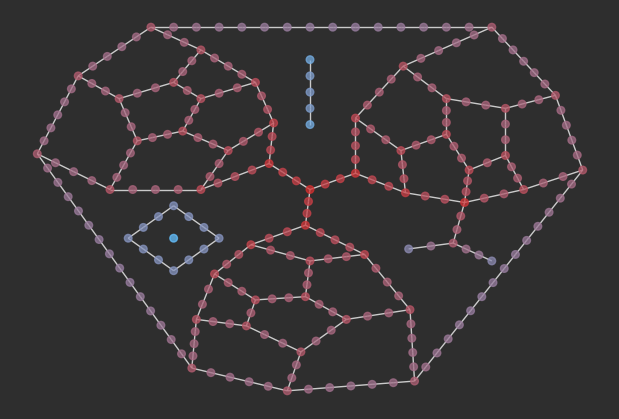

In [40]:
# plot centrality
from matplotlib import colors

segment_harmonic_vals = []
mixed_uses_vals = []
for node, data in G_metrics.nodes(data=True):
    segment_harmonic_vals.append(data['metrics']['centrality']['segment_harmonic'][800])
    mixed_uses_vals.append(data['metrics']['mixed_uses']['hill_branch_wt'][0][400])

# custom colourmap
cmap = colors.LinearSegmentedColormap.from_list('cityseer', ['#64c1ff', '#d32f2f'])

# normalise the values
segment_harmonic_vals = colors.Normalize()(segment_harmonic_vals)
# cast against the colour map
segment_harmonic_cols = cmap(segment_harmonic_vals)
# plot segment_harmonic
plot.plot_nX(G_metrics, labels=False, colour=segment_harmonic_cols, dpi=100)

In [41]:
# plot distance-weighted hill mixed uses
mixed_uses_vals = colors.Normalize()(mixed_uses_vals)
mixed_uses_cols = cmap(mixed_uses_vals)
plot.plot_assignment(N, D, node_colour=mixed_uses_cols, data_labels=landuse_labels, dpi=100)

TypeError: plot_assignment() got an unexpected keyword argument 'dpi'

Issues & Contributions
----------------------

Please report issues to the [`issues`](https://github.com/cityseer/cityseer-api/issues) page of the `cityseer` `github` repo.

Feature requests and contributions are welcome, and will be considered if within the remit of the package.